# GeoTrellis: The RasterSource API

## Setup

In [1]:
import $ivy.`org.locationtech.geotrellis::geotrellis-raster:3.6.0`
import geotrellis.raster._,
       geotrellis.raster.geotiff._,
       geotrellis.raster.render._

Downloaded https://repo1.maven.org/maven2/org/locationtech/geotrellis/geotrellis-raster_2.12/3.6.0/geotrellis-raster_2.12-3.6.0.pom
Downloaded https://repo1.maven.org/maven2/org/locationtech/geotrellis/geotrellis-util_2.12/3.6.0/geotrellis-util_2.12-3.6.0.pom
Downloaded https://repo1.maven.org/maven2/org/locationtech/geotrellis/geotrellis-macros_2.12/3.6.0/geotrellis-macros_2.12-3.6.0.pom
Downloaded https://repo1.maven.org/maven2/org/typelevel/squants_2.12/1.7.0/squants_2.12-1.7.0.pom
Downloaded https://repo1.maven.org/maven2/org/locationtech/geotrellis/geotrellis-vector_2.12/3.6.0/geotrellis-vector_2.12-3.6.0.pom
Downloaded https://repo1.maven.org/maven2/io/circe/circe-parser_2.12/0.13.0/circe-parser_2.12-0.13.0.pom
Downloaded https://repo1.maven.org/maven2/io/circe/circe-generic_2.12/0.13.0/circe-generic_2.12-0.13.0.pom
Downloaded https://repo1.maven.org/maven2/io/circe/circe-core_2.12/0.13.0/circe-core_2.12-0.13.0.pom
Downloaded https://repo1.maven.org/maven2/org/log4s/log4s_2.12/1.

import $ivy.$
import geotrellis.raster._,
       geotrellis.raster.geotiff._,
       geotrellis.raster.render._

## Reading a TIFF using RasterSource and Writing to PNG

Let's take a look at the `RasterSource` API.

In [2]:
val filePath = "https://download.osgeo.org/geotiff/samples/usgs/o41078a7.tif"
val localPath = "/home/jovyan/o41078a7.png"
val rasterSource = GeoTiffRasterSource(filePath)

filePath: String = "https://download.osgeo.org/geotiff/samples/usgs/o41078a7.tif"
localPath: String = "/home/jovyan/o41078a7.png"
rasterSource: GeoTiffRasterSource = GeoTiffRasterSource(https://download.osgeo.org/geotiff/samples/usgs/o41078a7.tif)

Note how quickly the above cell's output was computed. What black magic could explain such performance? Actually, this speed is explained by the fact that RasterSource creation is lazy. These can be created almost for free and stored in arrays by the tens of thousands for almost no memory overhead. This also means that they can be serialized by a distributed framework like Spark and shipped around for processing to appropriate nodes. Let's call `read` and use some pattern matching to destructure the optional return value so that we can render this sample OSGEO tiff. Types annotations are included for documentation purposes.

In [3]:
rasterSource.read() match {
    case Some(raster) =>
        val mbtile: MultibandTile = raster.tile
        val sbtile: Tile = mbtile.band(0)
        // This construct is a statistical representation of tiff contents.
        // We can use it to build a colormap that maximizes colors in the densest ranges of values
        val histogram: Histogram[Int] = sbtile.histogram
        // A colormap is essentially a dictionary pointing from values to colors.
        val cmap: ColorMap = ColorRamps.Viridis.toColorMap(histogram)
        // Beyond the scope of this workshop, the rendering code in GT is *heavily* optimized and is worth checking out to see how mutability can be used strategically.
        // https://github.com/locationtech/geotrellis/blob/519d7a7b18f2c4d4b7a16cc059d827bccce20995/raster/src/main/scala/geotrellis/raster/render/png/PngEncoder.scala
        val png: Png = sbtile.renderPng(cmap)
        // Now, we can write to the filesystem
        png.write(localPath)
    case None =>
        // Exceptions might live here, if you're into that kind of thing
        println("This shouldn't happen!")
}

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


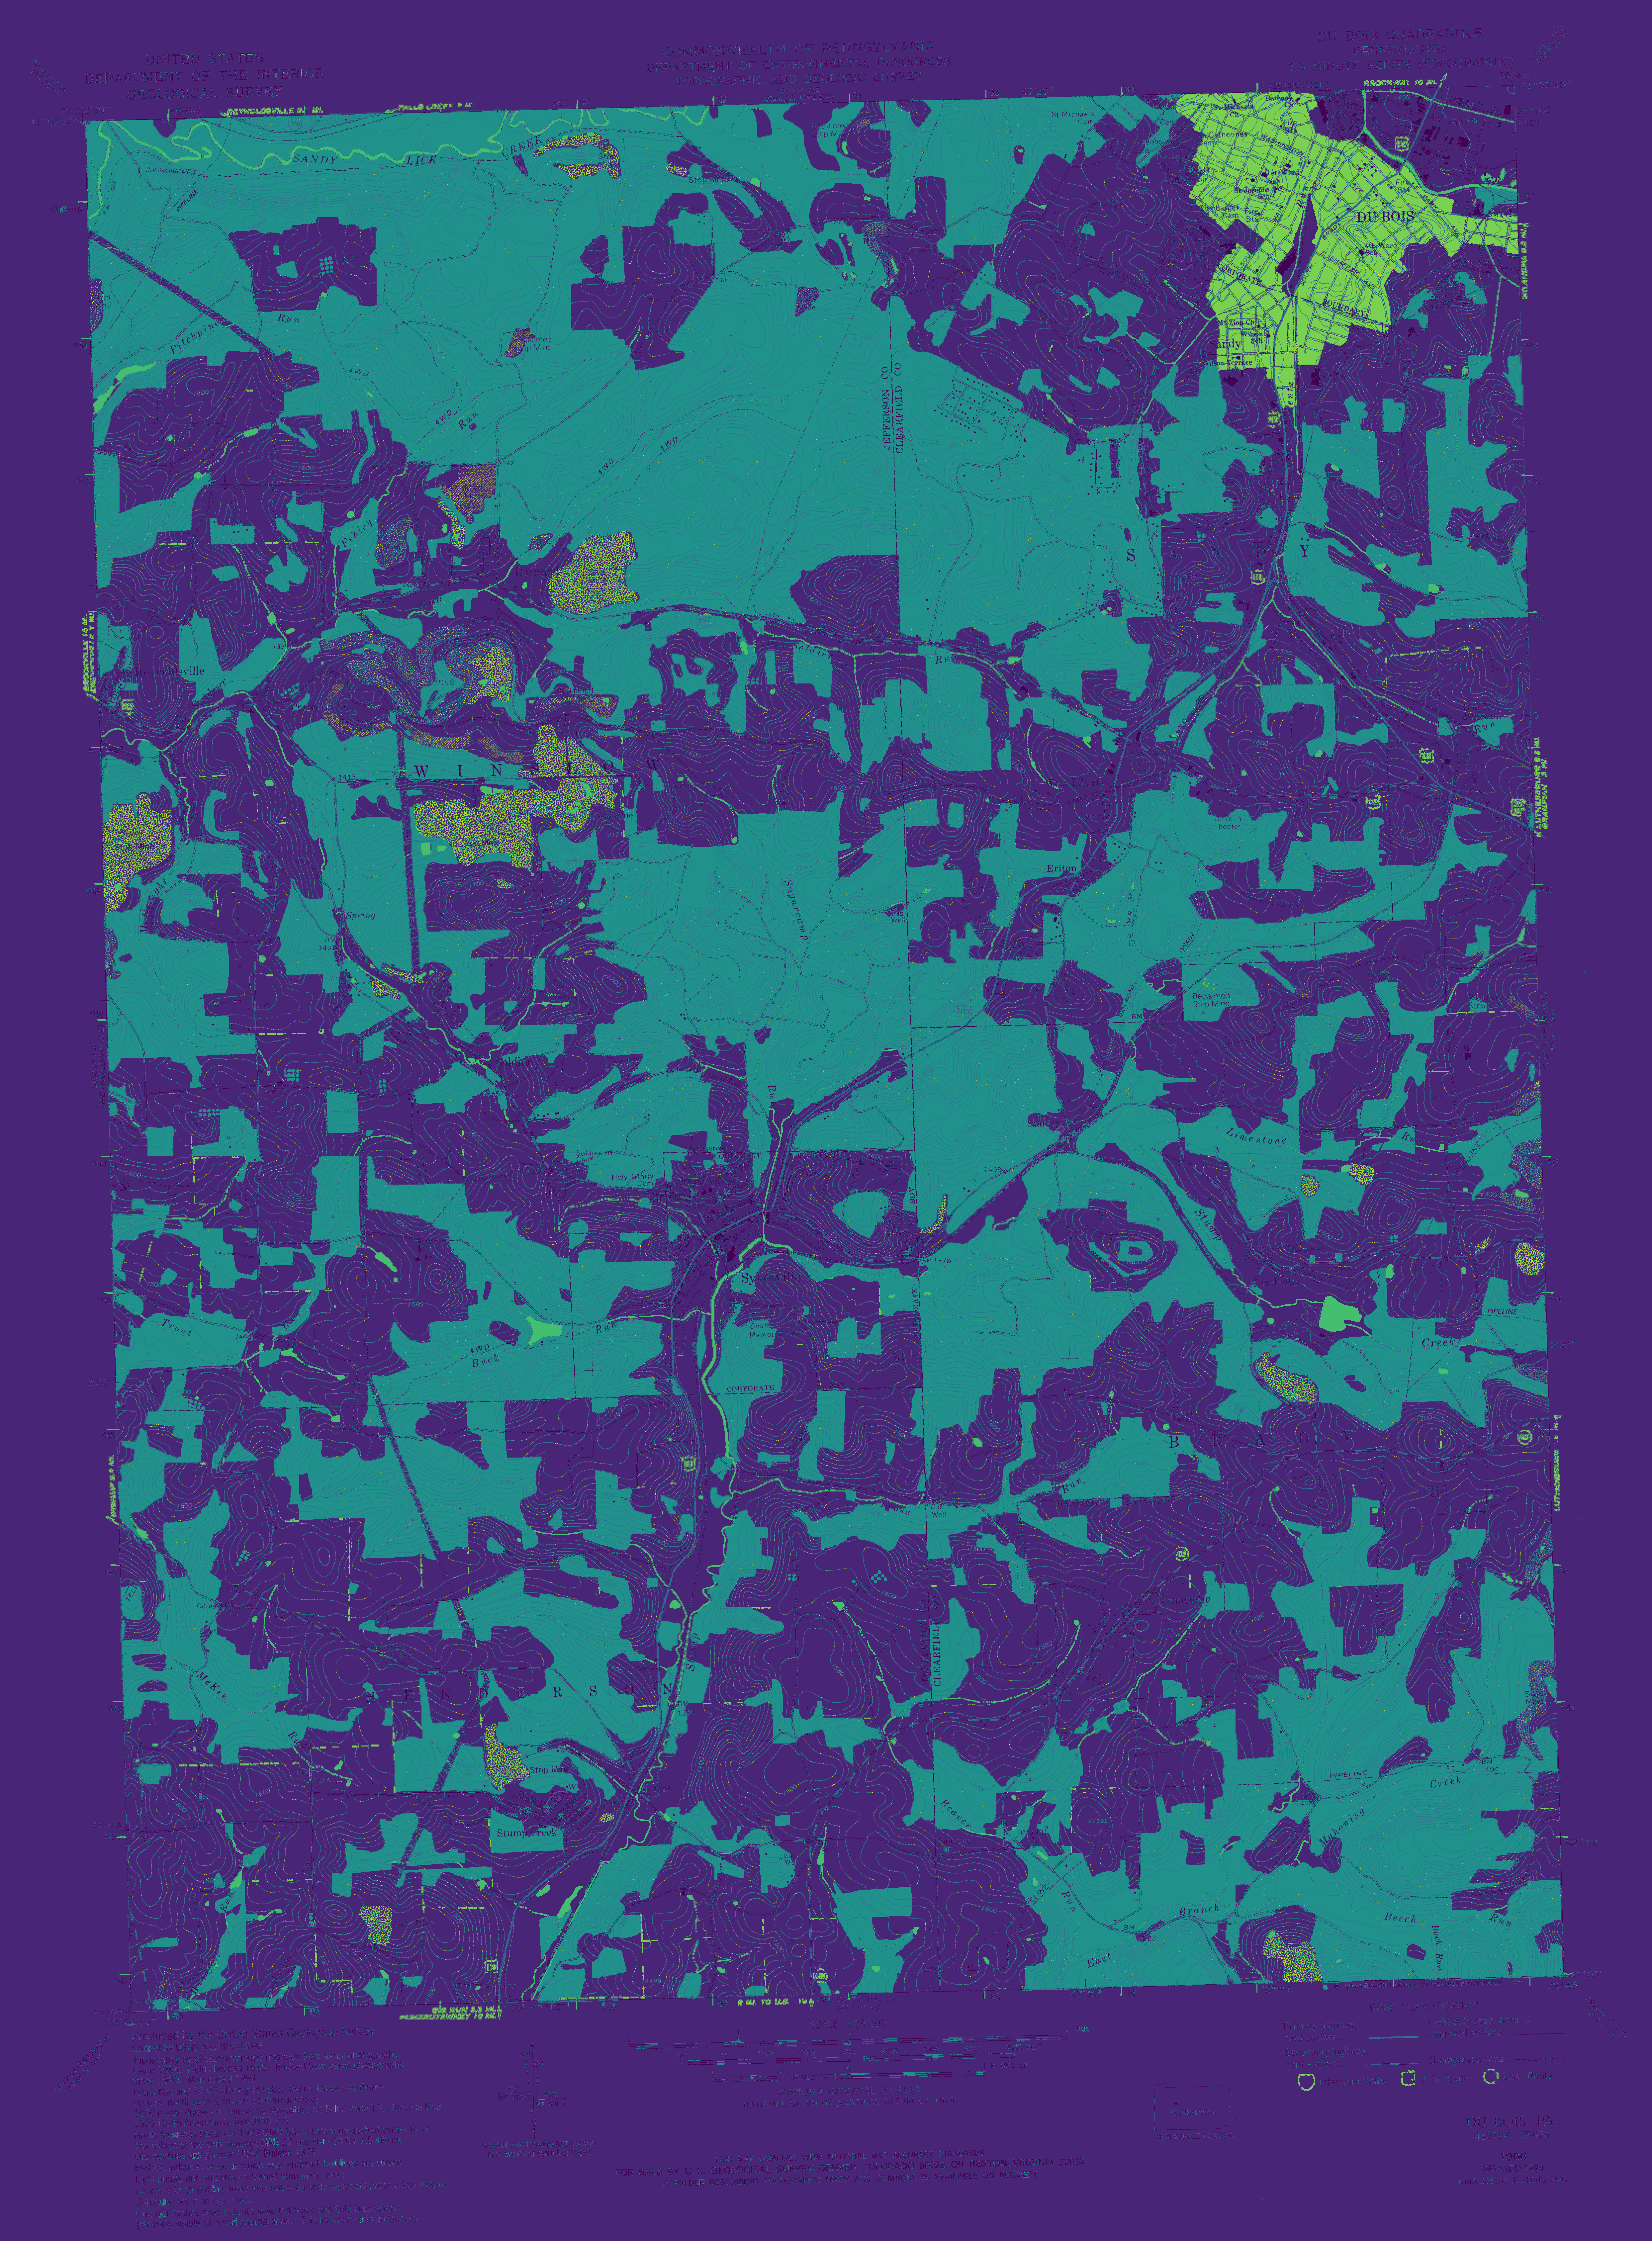

import almond.display._
import java.nio.file.{Files, Paths}
path: java.nio.file.Path = /home/jovyan/o41078a7.png

In [4]:
import almond.display._
import java.nio.file.{Files, Paths}

val path = Paths.get(localPath)
Image(Files.readAllBytes(path))

## Geospatial Metadata

The above tiff is strange. Apparently, an old USGS document that someone saw fit to orthorectify. But that means it has all the geospatial metadata we need to explore some of the other features which make `RasterSource` implementations so convenient. Let's take a look at at some of the metadata for this tiff.

Before we do that, it might be useful to mention that there is a construct in GeoTrellis which describes what it means for a class to have raster metadata. Recall that traits are just bundles of abstract properties. They can be stacked and combined with other abstraction mechanisms to represent the idea that the items to which they are applied fulfill a certain contract (whatever else they may do). Here's the [definition of `RasterSource`](https://github.com/locationtech/geotrellis/blob/519d7a7b18f2c4d4b7a16cc059d827bccce20995/raster/src/main/scala/geotrellis/raster/RasterSource.scala#L43), which includes the `RasterMetadata` trait and here's the [trait definition for `RasterMetadata`](https://github.com/locationtech/geotrellis/blob/519d7a7b18f2c4d4b7a16cc059d827bccce20995/raster/src/main/scala/geotrellis/raster/RasterMetadata.scala#L22).

In [5]:
// We only used the first (0th) band above. How many bands are there, total?
println(f"There is ${rasterSource.bandCount} band")

// What projection does it have?
println(f"The CRS for this tiff is ${rasterSource.crs}")

// What is its 'name' (Strictly speaking, a rastersource's need not be a URL. It could conceivably *generate* data and fulfill the obligations of its abstractions)
println(f"This source's name is ${rasterSource.name}")

// How big is each cell?/What is its ground sampling distance or GSD? (Keep in mind that units will depend on the projection!)
// EPSG:32617 is UTM, so the answer will be in meters. We will use %.2f to truncate the double down to a sensible hundredths place.
println(f"This raster's GSD width is ${rasterSource.cellSize.width}%.2fm, its height is ${rasterSource.cellSize.height}%.2fm.")

// The various extent notions found in geotrellis capture, at a minimum, a purported region within a coordinate system
val extent = rasterSource.gridExtent.extent
println(f"Minimum x: ${extent.xmin}. Minimum y: ${extent.ymin}")
println(f"Maximum x: ${extent.xmax}. Maximum y: ${extent.ymax}")
rasterSource.gridExtent
// In addition, however, a GridExtent captures information about how data is quantized within said Extent. In other words, info about resolution.
// Having already seen the CellSize above, let's instead look up the numbers of cols and rows
println(f"This tiff has ${rasterSource.gridExtent.cols} columns and ${rasterSource.gridExtent.rows} rows")


There is 1 band
The CRS for this tiff is EPSG:32617
This source's name is https://download.osgeo.org/geotiff/samples/usgs/o41078a7.tif
This raster's GSD width is 2.44m, its height is 2.44m.
Minimum x: 677765.001001. Minimum y: 4539028.483824
Maximum x: 689893.6026010001. Maximum y: 4555485.245424
This tiff has 4974 columns and 6749 rows


extent: geotrellis.vector.Extent = Extent(
  677765.001001,
  4539028.483824,
  689893.6026010001,
  4555485.245424
)
res5_7: GridExtent[Long] = GridExtent(Extent(677765.001001, 4539028.483824, 689893.6026010001, 4555485.245424), CellSize(2.438400000000011,2.4383999999999784), 4974x6749)

## Raster transformation

There are a number of different options when it comes to resizing and reshaping rasters. They correspond to the various values which make up GridExtent. Transforming the coordinate system in terms of which these values are specified, the size of the extent, the number of rows and columns, and the cellsize are all possible, so let's look at how this is done.

### Reprojecting

First, let's reproject this strange raster from its current UTM projection to WGS 1984, which has the EPSG code of 4326.

In [6]:
// First, we'll need to pull in the geotrellis proj4 package
import geotrellis.proj4._

// Now, we can have geotrellis carry out reprojection for us
rasterSource.reproject(LatLng)

// Or not. RasterSource transformations tend to avoid mutation and to favor function purity.
println(f"We expected EPSG:4326 (LatLng). Instead, we got: ${rasterSource.crs}")

// We'll actually want to save the output of the reproject method.
val latlngRasterSource = rasterSource.reproject(LatLng)
println(f"Now, as expected, the raster should have a EPSG code of 4326: ${latlngRasterSource.crs.epsgCode}")

// Let's see if the extent has changed. LatLng values ought to be quite a bit smaller than those designated in meters
println(f"The old extent is ${rasterSource.gridExtent.extent}")
println(f"The updated extent is ${latlngRasterSource.gridExtent.extent}")

We expected EPSG:4326 (LatLng). Instead, we got: EPSG:32617
Now, as expected, the raster should have a EPSG code of 4326: Some(4326)
The old extent is Extent(677765.001001, 4539028.483824, 689893.6026010001, 4555485.245424)
The updated extent is Extent(-78.88691321713993, 40.98032934207747, -78.73777082766729, 41.131217714731925)


import geotrellis.proj4._
res6_1: RasterSource = GeoTiffReprojectRasterSource(https://download.osgeo.org/geotiff/samples/usgs/o41078a7.tif, LatLng, DefaultTarget, NearestNeighbor)
latlngRasterSource: RasterSource = GeoTiffReprojectRasterSource(https://download.osgeo.org/geotiff/samples/usgs/o41078a7.tif, LatLng, DefaultTarget, NearestNeighbor)

### Resizing

Next, let's see what can be done to change the actual geographic region over which the image is stretched. This is less common than reprojection or resampling, but it is extremely straightforward.

In [ ]:
import geotrellis.vector.Extent
val targetRegion = {
    val cols = latlngRasterSource.gridExtent.cols
    val rows = latlngRasterSource.gridExtent.rows
    GridExtent(Extent(-80, 40, -77, 44), cols, rows)
}
val resizedRaster = latlngRasterSource.resampleToRegion(targetRegion)
resizedRaster.gridExtent

// No good reason to view this image; it ought to render exactly as before

### Resampling

Resampling to a given `CellSize` looks a lot like resizing. We'll downsample the original raster to the point that artifacts are obvious, just to see how things work

In [7]:
// For ease of specifying a reasonable cellsize, we'll resample the UTM RasterSource that we started with
val targetGrid = {
    val cs = CellSize(20, 20)
    // The below type argument is an unfortunate consequence of performance enhancements related to JVM boxing rules
    // See the notebook in directory 1-Scala pertaining to boxing and spire optimizations for more
    GridExtent[Long](rasterSource.gridExtent.extent, cs)
}
val resampledRasterSource = rasterSource.resampleToGrid(targetGrid)
resampledRasterSource.gridExtent

targetGrid: GridExtent[Long] = GridExtent(Extent(677765.001001, 4539028.483824, 689893.6026010001, 4555485.245424), CellSize(20.0,20.0), 606x823)
resampledRasterSource: RasterSource = GeoTiffResampleRasterSource(https://download.osgeo.org/geotiff/samples/usgs/o41078a7.tif, TargetAlignment(GridExtent(Extent(677765.001001, 4539028.483824, 689893.6026010001, 4555485.245424), CellSize(20.0,20.0), 606x823)), NearestNeighbor)
res7_2: GridExtent[Long] = GridExtent(Extent(677765.001001, 4539025.245424, 689905.001001, 4555485.245424), CellSize(20.0,20.0), 607x823)

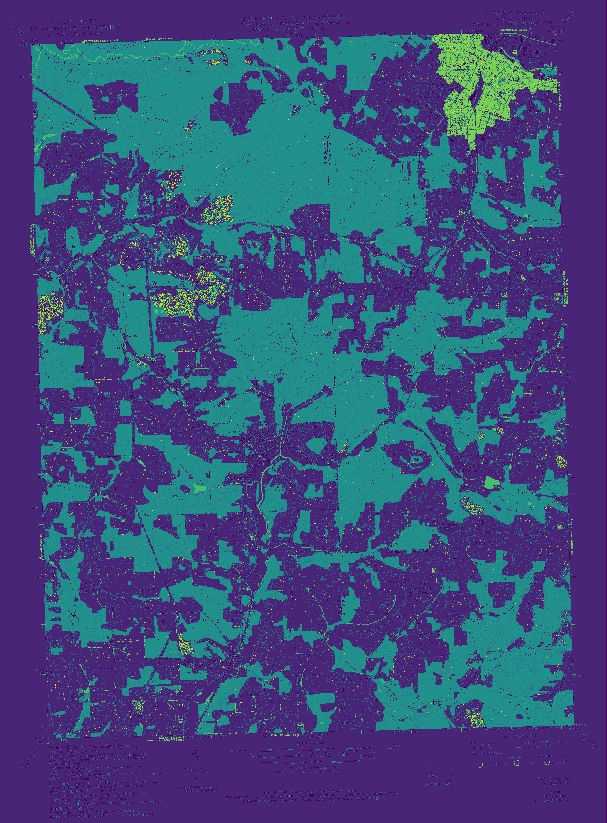

localResampledPath: String = "/home/jovyan/o41078a7_resample.png"
resampledPath: java.nio.file.Path = /home/jovyan/o41078a7_resample.png

In [8]:
// Let's render this resampled raster to get a sense of the impacts of dramatically lower resolution
val localResampledPath = "/home/jovyan/o41078a7_resample.png"

resampledRasterSource.read() match {
    case Some(raster) =>
        val mbtile: MultibandTile = raster.tile
        val sbtile: Tile = mbtile.band(0)
        val histogram: Histogram[Int] = sbtile.histogram
        val cmap: ColorMap = ColorRamps.Viridis.toColorMap(histogram)
        val png: Png = sbtile.renderPng(cmap)
        png.write(localResampledPath)
    case None =>
        println("This shouldn't happen!")
}
val resampledPath = Paths.get(localResampledPath)
Image(Files.readAllBytes(resampledPath))

## Reading Segments

We've see the `read` method which takes no parameters, above. Now, let's look to one of the available overload methods of `read` which allows us to realize only a portion of a raster. If using a tiled tiff structure (e.g. with any COG), reads specifying a subset of the total tiff will intelligently grab only the tiles that have overlap with that subset of the total tiff.

In [9]:
val localResampledSubsetPath = "/home/jovyan/o41078a7_resample_subset.png"

// Recall that the resampledRasterSource has 607 columns and 823 rows.
// We can select specific cols/rows for reading.
// Again, note the unfortunate type parameter tradeoff incurred due to optimization
val gb = GridBounds[Long](colMin = 100, rowMin = 100, colMax = 400, rowMax = 400)
resampledRasterSource.read(gb) match {
    case Some(raster) =>
        val mbtile: MultibandTile = raster.tile
        val sbtile: Tile = mbtile.band(0)
        val histogram: Histogram[Int] = sbtile.histogram
        val cmap: ColorMap = ColorRamps.Viridis.toColorMap(histogram)
        val png: Png = sbtile.renderPng(cmap)
        png.write(localResampledSubsetPath)
    case None =>
        println("This shouldn't happen!")
}
val resampledSubsetPath = Paths.get(localResampledSubsetPath)
Image(Files.readAllBytes(resampledSubsetPath))

localResampledSubsetPath: String = "/home/jovyan/o41078a7_resample_subset.png"
gb: GridBounds[Long] = GridBounds(100L, 100L, 400L, 400L)
resampledSubsetPath: java.nio.file.Path = /home/jovyan/o41078a7_resample_subset.png

Other mechanisms for reading subsets exist. To get a better idea of what's possible, [check out](https://github.com/locationtech/geotrellis/blob/519d7a7b18f2c4d4b7a16cc059d827bccce20995/raster/src/main/scala/geotrellis/raster/RasterSource.scala#L43) the `Extent` consuming `read` method and the `read` method that only reads the selected bands. Can you tell what `readExtents` does? Remember to use the type signature if you're not sure.